# TM10007 Assignment template

In [17]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [1]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data

# Import classifiers
from sklearn import model_selection

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# create the training data
X = data.drop("label",axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
print(X_train.shape)

The number of samples: 115
The number of columns: 494
(86, 493)


In [2]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def load_breast_cancer(n_features=2):
    '''
    Load the sklearn breast data set, but reduce the number of features with PCA.
    '''
    data = ds.load_breast_cancer()
    x = data['data']
    y = data['target']

    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

def load_boston(n_features=1):
    '''
    Load the sklearn boston data set, but reduce the number of features with PCA.
    '''
    data = ds.load_boston()
    x = data['data']
    y = data['target']

    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

def load_diabetes(n_features=1):
    '''
    Load the sklearn bdiabetes data set, but reduce the number of features with PCA.
    '''
    data = ds.load_diabetes()
    x = data['data']
    y = data['target']

    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y



### Preprocessing

Missing data

## Feature extraction

### Lloyd: greedy feature selection, forward

In [ ]:
%pip install mlxtend

# Greedy feature selection (forward)

# importing the models
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# calling the classifier for the feature selction
clf = LogisticRegression(max_iter=500, random_state=42)
svc = svm.SVC(kernel="linear")

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Greedy forward selection and fitting (select 10 best features)
sfs1 = SequentialFeatureSelector(clf, n_features_to_select=10, direction='forward', scoring='accuracy', cv=cv)
sfs1.fit(X_train, y_train)

# print selected feature names
selected_features = X_train.columns[sfs1.get_support()]
print("Selected features:", selected_features)



Note: you may need to restart the kernel to use updated packages.


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Selected features: Index(['PREDICT_original_sf_compactness_std_2.5D',
       'PREDICT_original_sf_convexity_std_2.5D',
       'PREDICT_original_sf_cvar_avg_2.5D',
       'PREDICT_original_sf_prax_std_2.5D',
       'PREDICT_original_sf_evar_avg_2.5D',
       'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_volume_2.5D',
       'PREDICT_original_hf_skewness',
       'PREDICT_original_logf_peak_position_sigma1',
       'PREDICT_original_tf_LBP_range_R8_P24'],
      dtype='object')


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
# creating a new dataframe using the above variables and adding the target var
new_data = data[selected_features]
new_data['label'] = data['label']

new_data.head()
new_data.shape

C:\Users\lloyd\AppData\Local\Temp\ipykernel_78168\3146694808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['label'] = data['label']


(115, 11)

### Lloyd: Recursive Feature Elimination with Cross-Validation (RFECV)


Dit is de basis code voor RFECV (duurt oneindig lang omdat je dus met 500 features begint)

In [ ]:
# Recursive Feature Elimination with Cross-Validation (RFECV)

# Import libraries
from sklearn import feature_selection
from sklearn import svm
import matplotlib.pyplot as plt

# calling the classifier (SVM model) for the feature selection
svc = svm.SVC(kernel="linear")

# RFECV feature selection and fitting
rfecv = feature_selection.RFECV(
    estimator=svc, step=5,
    cv=model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# print selected feature names
selected_features = X_train.columns[sfs1.get_support()]
print("Selected features:", selected_features)

# plot the number of features vs. accuracy
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

KeyboardInterrupt: 

### Lloyd: univariate feature selection

This works by selecting the best features based on univariate statistical tests. Scikit-learn exposes feature selection routines as objects that implement the transform method: 

* SelectKBest: removes all but the k highest scoring features (e.g. score on an F-test)
* SelectPercentile removes all but a user-specified highest scoring percentage of features

These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):

* For regression: r_regression, f_regression, mutual_info_regression

* For classification: chi2, f_classif, mutual_info_classif

                                           Feature  F-Statistic   p-value
20                 PREDICT_original_sf_volume_2.5D    22.153640  0.000010
17               PREDICT_original_sf_area_max_2.5D    13.909135  0.000347
19               PREDICT_original_sf_area_std_2.5D    13.117389  0.000500
16               PREDICT_original_sf_area_avg_2.5D    12.102719  0.000800
321     PREDICT_original_tf_Gabor_energy_F0.2_A0.0    10.237403  0.001942
..                                             ...          ...       ...
481    PREDICT_original_phasef_phasesym_max_WL3_N5     2.911543  0.091642
489  PREDICT_original_phasef_phasesym_range_WL3_N5     2.911543  0.091642
94         PREDICT_original_tf_LBP_skewness_R8_P24     2.884182  0.093155
274     PREDICT_original_tf_Gabor_mean_F0.05_A0.79     2.835237  0.095930
106            PREDICT_original_tf_LBP_std_R15_P36     2.820790  0.096767

[100 rows x 3 columns]


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 76  77  85  90  96  97 103 422 423 435 436 448 449 467 474 475 480 487
 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


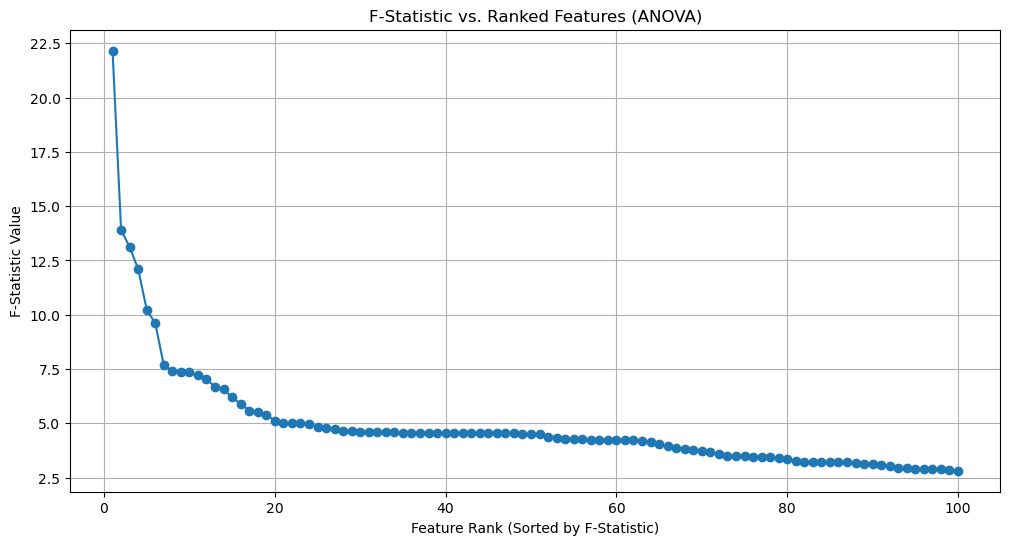

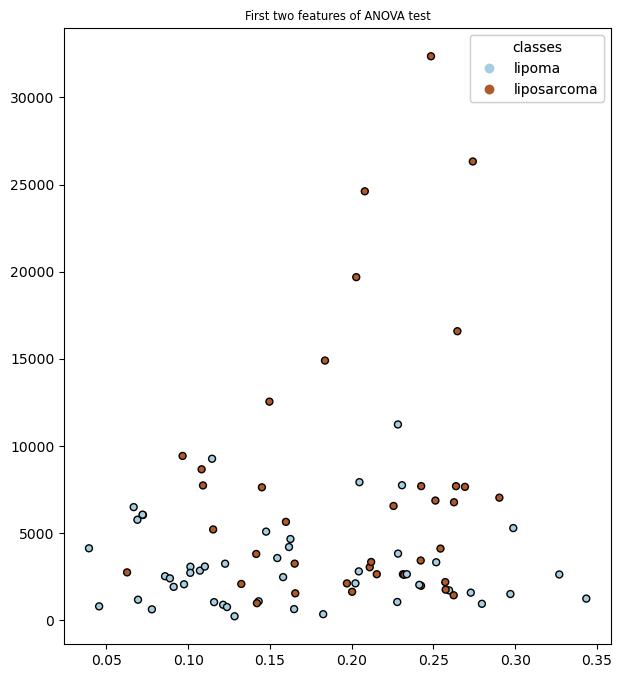

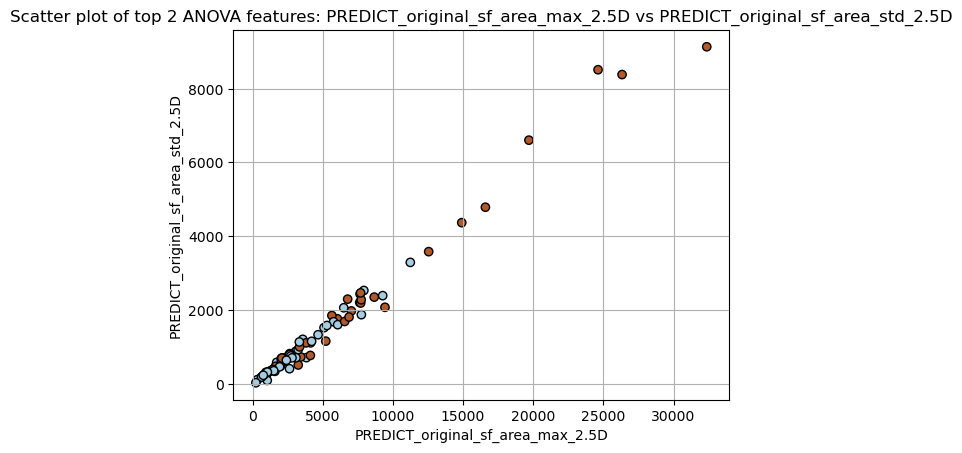

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Zet de labels om naar numerieke waarden
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
legend_labels = le.classes_  # Toont de mapping van labels naar nummers

# ANOVA F-test (lineaire relaties)
selector_anova = SelectKBest(f_classif, k=100)
X_filtered_anova = selector_anova.fit_transform(X_train, y_train)
anova_features = X_train.columns[selector_anova.get_support()]
# print(anova_features)
f_values, p_values = selector_anova.scores_, selector_anova.pvalues_

# Create a DataFrame to display features with their corresponding F-statistics and p-values
anova_results = pd.DataFrame({'Feature': X_train.columns,'F-Statistic': f_values, 'p-value': p_values})

# Sort by F-statistic (highest to lowest) to find the most statistically significant features
anova_results_sorted_by_F = anova_results.sort_values(by='F-Statistic', ascending=False)
anova_results_sorted_by_F = anova_results_sorted_by_F[anova_results_sorted_by_F['Feature'].isin(anova_features)]
print(anova_results_sorted_by_F)

# Plot de F-statistic per feature
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(anova_results_sorted_by_F) + 1), anova_results_sorted_by_F['F-Statistic'], marker='o')
plt.xlabel("Feature Rank (Sorted by F-Statistic)")
plt.ylabel("F-Statistic Value")
plt.title("F-Statistic vs. Ranked Features (ANOVA)")
plt.grid(True)
plt.show()

# Mutual Information (niet-lineaire relaties)
X_filtered_mi = SelectKBest(mutual_info_classif, k=100).fit_transform(X_train, y_train)
mi_features = X_train.columns[SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train).get_support()]

# Gemeenschappelijke features
common_features = list(set(anova_features).intersection(set(mi_features)))

# Unieke features voor ANOVA en MI
unique_anova = list(set(anova_features) - set(mi_features))
unique_mi = list(set(mi_features) - set(anova_features))

# Print de resultaten
# print("Selected features using ANOVA:", anova_features)
# print("Selected features using Mutual Information:", mi_features)
# print("Common features (selected by both ANOVA and MI):", common_features)
# print("Unique features to ANOVA:", unique_anova)
# print("Unique features to MI:", unique_mi)
# print(len(common_features))

fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title("First two features of ANOVA test", fontsize='small')
scatter = ax.scatter(X_filtered_anova[:, 0], X_filtered_anova[:, 2], marker='o', c=y_train_numeric,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

# Haal de juiste legenda-elementen op
handles, _ = scatter.legend_elements()
legend1 = ax.legend(handles, legend_labels, title="classes")
ax.add_artist(legend1)
plt.show()

example_features = anova_results_sorted_by_F.iloc[1:3]['Feature'].values
ax = fig.add_subplot(132)
plt.scatter(X_train[example_features[0]], X_train[example_features[1]], c=y_train_numeric, cmap=plt.cm.Paired, edgecolor='k')
plt.xlabel(example_features[0])
plt.ylabel(example_features[1])
plt.title(f"Scatter plot of top 2 ANOVA features: {example_features[0]} vs {example_features[1]}")
plt.grid(True)

plt.show()

Idea: first univariate selection (500 -> 100 features), then test both methods (ANOVA and MI) with RFE. The same can be done for SFS. 

In [ ]:
# Further Feature Selection with RFE

# import modules
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import svm

# calling the classifier (SVM model or linear regression) for the feature selection
svc = svm.SVC(kernel="linear")
# clf = LogisticRegression(max_iter=500, random_state=42)

cv = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# RFECV feature selection and fitting
rfecv_anova = feature_selection.RFECV(estimator=svc,
                                      step=5,
                                      cv=cv,
                                      scoring='roc_auc')

rfecv_mi = feature_selection.RFECV(estimator=svc,
                                   step=5,
                                   cv=cv,
                                   scoring='roc_auc')

rfecv_anova.fit(X_filtered_anova, y_train)
rfecv_mi.fit(X_filtered_mi, y_train)

Features selected with ANOVA and RFECV: ['PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_tf_LBP_entropy_R15_P36', 'PREDICT_original_tf_Gabor_energy_F0.2_A0.0']
Features selected with MI and RFECV:: ['PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_of_theta_y', 'PREDICT_original_tf_GLCM_homogeneityd1.0A0.0', 'PREDICT_original_tf_GLCM_homogeneityd3.0A0.79', 'PREDICT_original_tf_GLCMMS_homogeneityd1.0A0.0mean', 'PREDICT_original_tf_GLCMMS_homogeneityd1.0A1.57std', 'PREDICT_original_tf_Gabor_kurtosis_F0.05_A0.0', 'PREDICT_original_tf_Gabor_energy_F0.5_A0.0', 'PREDICT_original_vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_phasef_phasesym_energy_WL3_N5']
Number of features selected with ANOVA and RFECV: 5
Number of features  selected with MI and RFECV: 10


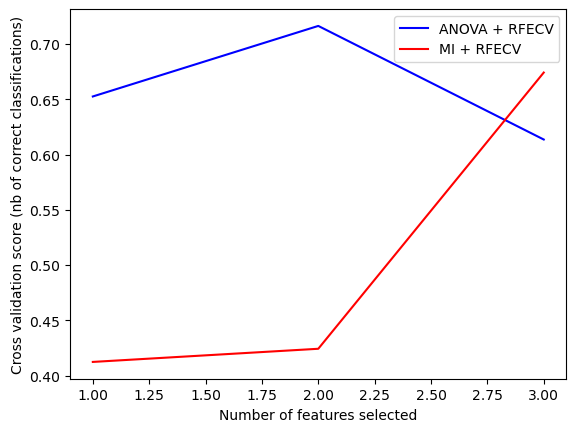

In [22]:
# print selected feature names and the number of features selected
selected_features_anova = anova_features[rfecv_anova.support_]
selected_features_mi = mi_features[rfecv_mi.support_]

print("Features selected with ANOVA and RFECV:", list(selected_features_anova))
print("Features selected with MI and RFECV::", list(selected_features_mi))

print("Number of features selected with ANOVA and RFECV:", sum(rfecv_anova.support_))
print("Number of features  selected with MI and RFECV:", sum(rfecv_mi.support_))

# plot the number of features vs. accuracy
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_anova.cv_results_["mean_test_score"]) + 1), rfecv_anova.cv_results_["mean_test_score"], label="ANOVA + RFECV", color="blue")
plt.plot(range(1, len(rfecv_mi.cv_results_["mean_test_score"]) + 1), rfecv_mi.cv_results_["mean_test_score"], label="MI + RFECV", color="red")
plt.legend()
plt.show()

Inge

Scaling data